In [58]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import math
import numpy as np

In [ ]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # In case of error, don't draw the line
    draw_right = True
    draw_left = True
    
    # Find slopes of all lines
    # But only care about lines where abs(slope) > slope_threshold
    slope_threshold =0.8
    slopes = []
    new_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]  # line = [[x1, y1, x2, y2]]
        
        # Calculate slope
        if x2 - x1 == 0.:  # corner case, avoiding division by 0
            slope = 999.  # practically infinite slope
        else:
            slope = (y2 - y1) / (x2 - x1)
        
        # Filter lines based on slope
        if abs(slope) > slope_threshold:
            slopes.append(slope)
            new_lines.append(line)
        
    lines = new_lines
    print(len(lines))
    right_lines = []
    left_lines = []
    for i, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]
        img_x_center = img.shape[1] / 2  # x coordinate of center of image
        if slopes[i] > 0 and x1 > img_x_center and x2 > img_x_center:
            right_lines.append(line)
        elif slopes[i] < 0 and x1 < img_x_center and x2 < img_x_center:
            left_lines.append(line)
            
  
    right_lines_x = []
    right_lines_y = []
    
    for line in right_lines:
        x1, y1, x2, y2 = line[0]
        
        right_lines_x.append(x1)
        right_lines_x.append(x2)
        
        right_lines_y.append(y1)
        right_lines_y.append(y2)
        
    if len(right_lines_x) > 0:
        right_m, right_b = np.polyfit(right_lines_x, right_lines_y, 1)  # y = m*x + b
    else:
        right_m, right_b = 1, 1
        draw_right = False
        
    
    left_lines_x = []
    left_lines_y = []
    
    for line in left_lines:
        x1, y1, x2, y2 = line[0]
        
        left_lines_x.append(x1)
        left_lines_x.append(x2)
        
        left_lines_y.append(y1)
        left_lines_y.append(y2)
        
    if len(left_lines_x) > 0:
        left_m, left_b = np.polyfit(left_lines_x, left_lines_y, 1)  # y = m*x + b
    else:
        left_m, left_b = 1, 1
        draw_left = False
    
    
    y1 = img.shape[0]
    y2 = img.shape[0] * (1 - trap_height)
    
    right_x1 = (y1 - right_b) / right_m
    right_x2 = (y2 - right_b) / right_m
    
    left_x1 = (y1 - left_b) / left_m
    left_x2 = (y2 - left_b) / left_m
    
    
    y1 = int(y1)
    y2 = int(y2)
    right_x1 = int(right_x1)
    right_x2 = int(right_x2)
    left_x1 = int(left_x1)
    left_x2 = int(left_x2)
    
   
    if draw_right:
        cv2.line(img, (right_x1, y1), (right_x2, y2), color, thickness)
    if draw_left:
        cv2.line(img, (left_x1, y1), (left_x2, y2), color, thickness)

    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    print(lines.shape)
    #line_img = np.zeros(img.shape, dtype=np.uint8)  # this produces single-channel (grayscale) image
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)  # 3-channel RGB image
    draw_lines(line_img, lines)
    #draw_lines_debug2(line_img, lines)
    return line_img

In [59]:
def read_and_display(iname):
    
    if type(iname) == str:
        #read image
        img1 = cv2.imread(iname)
    else:
        img1 = iname
        
    if len(img1.shape) == 3:
        #convert to gray
        gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    else:
        gray1 = iname
    
    #size of image
    h1, w1 = img1.shape[:2]

    #calculate histogram
    hist1 = cv2.calcHist(
                        [gray1],
                        channels=[0],
                        mask=None, #full image
                        histSize=[256], #full scale
                        ranges=[0,256]
    )

    # normalized histogram
    norm_hist1 = hist1/(h1*w1)
    #cumulative histogram
    cdf1 = norm_hist1.cumsum()
    
    #plot image
    
    plt.subplot(2,2,1)
    plt.imshow(img1[:,:,::-1])
    plt.title("color image")
    plt.subplot(2, 2, 2)
    plt.stem(range(256), hist1, use_line_collection=True)
    plt.title("histogram")
    plt.subplot(2, 2, 3)
    plt.imshow(gray1, cmap='gray')
    plt.title("grayscale image")
    plt.subplot(2, 2, 4)
    plt.step(range(256), cdf1, c='g')
    plt.title("cumulative histogram")
    plt.show()


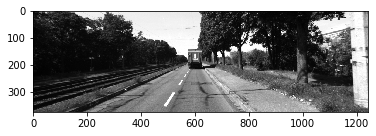

In [508]:
image = cv2.imread('um_000046.png')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image,cmap='gray')


Text(0.5, 1.0, 'histogram')

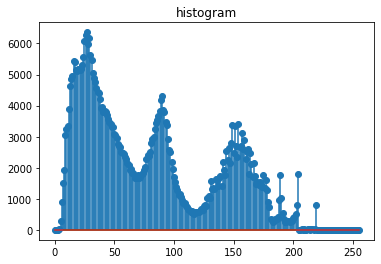

In [436]:
height,width,__ = image.shape
hist1 = cv2.calcHist(
                        [gray_image],
                        channels=[0],
                        mask=None, #full image
                        histSize=[256], #full scale
                        ranges=[0,256]
    )
norm_hist1 = hist1/(height*width)
cdf1 = norm_hist1.cumsum()
plt.step(range(256), cdf1, c='g')
plt.title("cumulative histogram")
plt.stem(range(256), hist1, use_line_collection=True)
plt.title("histogram")

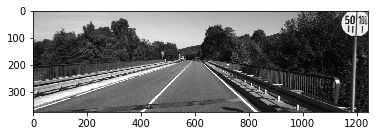

In [535]:
image = cv2.imread('um_000068.png')
height,width,__ = image.shape
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image,cmap='gray')

True

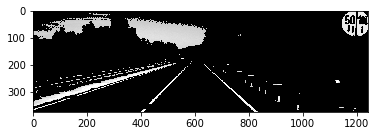

In [536]:
thres_light = 200
t = gray_image
im_thres = t.copy()
for x,y in zip(*np.where(t<thres_light)):
    im_thres[x,y] = 0
plt.imshow(im_thres,cmap='gray')
cv2.imwrite('image.png',im_thres)

True

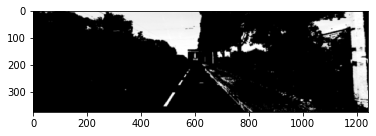

In [510]:
kernel_size = 9
gray_blur = cv2.GaussianBlur(im_thres, (kernel_size, kernel_size), 0)
plt.imshow(gray_blur,cmap='gray')
cv2.imwrite('image.png',gray_blur)

True

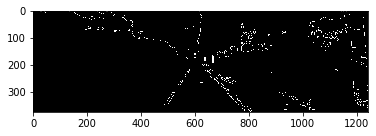

In [533]:
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(gray_blur, low_threshold, high_threshold)
plt.imshow(edges,cmap='gray')
cv2.imwrite('image.png',edges)

True

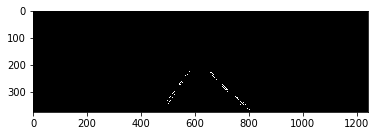

In [476]:
imshape = image.shape
trap_bottom_width = 0.65 
trap_top_width = 0.07 
trap_height = 0.4  
vertices = np.array([[\
        ((imshape[1] * (1 - trap_bottom_width)) // 2, imshape[0]),\
        ((imshape[1] * (1 - trap_top_width)) // 2, imshape[0] - imshape[0] * trap_height),\
        (imshape[1] - (imshape[1] * (1 - trap_top_width)) // 2, imshape[0] - imshape[0] * trap_height),\
        (imshape[1] - (imshape[1] * (1 - trap_bottom_width)) // 2, imshape[0])]]\
        , dtype=np.int32)
mask_color = 255

mask = np.zeros_like(edges)
verices = []
cv2.fillPoly(mask, vertices,mask_color)
masked_image = cv2.bitwise_and(edges, mask)
plt.imshow(masked_image,cmap='gray')
cv2.imwrite('image.png',masked_image)

In [514]:
def remote_outliners_line(lines,lower_thres = 0.8,upper_thres=1.5):
    slopes = []
    new_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]  # line = [[x1, y1, x2, y2]]
    
        if x2 - x1 == 0.:  
            continue
        else:
            slope = (y2 - y1) / (x2 - x1)   
        
        if abs(slope) > upper_thres:
            continue
        if abs(slope) > lower_thres:
            slopes.append(slope)
            new_lines.append(line)
    return new_lines

def classify_left_right_line(lines,image):
    img = np.array(image)
    right_lines = []
    left_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        img_x_center = img.shape[1] / 2  # x coordinate of center of image
        slope = (y2 - y1) / (x2 - x1)  
        if slope > 0 and x1 > img_x_center and x2 > img_x_center:
            right_lines.append(line)
        elif slope < 0 and x1 < img_x_center and x2 < img_x_center:
            left_lines.append(line)
            
    return right_lines,left_lines

def draw_lines(right_lines,left_lines,img):
    
    color = (0,0,255)
    thickness = 5
    draw_right = True
    draw_left = True
    right_lines_x = []
    right_lines_y = []
    for line in right_lines:
        x1, y1, x2, y2 = line[0]
        right_lines_x.append(x1)
        right_lines_x.append(x2)
        right_lines_y.append(y1)
        right_lines_y.append(y2)
        
    if len(right_lines_x) > 0:
        right_m, right_b = np.polyfit(right_lines_x, right_lines_y, 1)  # y = m*x + b
    else:
        right_m, right_b = 1, 1
        draw_right = False
        

    left_lines_x = []
    left_lines_y = []
    for line in left_lines:
        x1, y1, x2, y2 = line[0]
        left_lines_x.append(x1)
        left_lines_x.append(x2)
        left_lines_y.append(y1)
        left_lines_y.append(y2)
    if len(left_lines_x) > 0:
        left_m, left_b = np.polyfit(left_lines_x, left_lines_y, 1)  # y = m*x + b
    else:
        left_m, left_b = 1, 1
        draw_left = False
    y1 = int(img.shape[0])
    y2 = int(img.shape[0] * (1 - trap_height))
    right_x1 = int((y1 - right_b) / right_m)
    right_x2 = int((y2 - right_b) / right_m)
    left_x1 = int((y1 - left_b) / left_m)
    left_x2 = int((y2 - left_b) / left_m)
    
    t = [right_x1, y1,right_x2, y2,left_x1, y1,left_x2, y2]
    
    if draw_right:
        cv2.line(img, (right_x1, y1), (right_x2, y2), color, thickness)
    if draw_left:
        cv2.line(img, (left_x1, y1), (left_x2, y2), color, thickness)
    return img,t
        


In [454]:
def draw(lines,image):
    cop = image.copy()
    for l in lines:
        x1,y1,x2,y2 = l[0]
        x_1 = 0
        y_1 = int((y1-y2)/(x1-x2)*(x_1-x1) + y1)

        x_2 = cop.shape[1]
        y_2 = int((y1-y2)/(x1-x2)*(x_2-x1) + y1)
        cv2.line(cop,(x_1,y_1),(x_2,y_2),(0,0,255),1)
    return cop 

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)


In [515]:
rho = 2 
theta = 1 * np.pi/180 
threshold = 15     
min_line_len =  10 
max_line_gap = 20    
lines = cv2.HoughLinesP(masked_image, rho, theta, threshold, np.array([]), 
                        minLineLength=min_line_len, maxLineGap=max_line_gap)

image_line = draw(lines,image)
plt.imshow(image_line[:,:,::-1])
plt.show()
cv2.imwrite('1.png',image_line)

ValueError: too many values to unpack (expected 2)

True

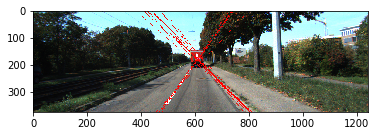

In [483]:
new_lines = remote_outliners_line(lines)
image_line = draw(new_lines,image)
plt.imshow(image_line[:,:,::-1])
cv2.imwrite('1.png',image_line)

True

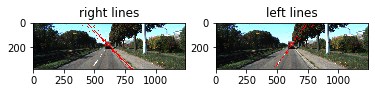

In [485]:
line_img = np.zeros((*masked_image.shape, 3), dtype=np.uint8)
right_lines,left_lines = classify_left_right_line(new_lines,line_img)

image_line = draw(right_lines,image)
plt.subplot(2,2,1)
plt.imshow(image_line[:,:,::-1])
plt.title("right lines")
cv2.imwrite('right.png',image_line)

image_line = draw(left_lines,image)
plt.subplot(2,2,2)
plt.imshow(image_line[:,:,::-1])
plt.title("left lines")
cv2.imwrite('left.png',image_line)

True

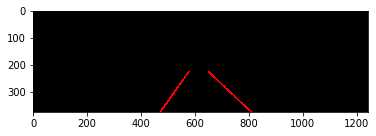

In [516]:
mask_line_image,t = draw_lines(right_lines,left_lines,line_img)
plt.imshow(mask_line_image[:,:,::-1])
cv2.imwrite('mask.png',mask_line_image)

In [517]:
t

[809, 375, 649, 225, 471, 375, 578, 225]

In [532]:
cv2.imwrite('ok.png',im)

True

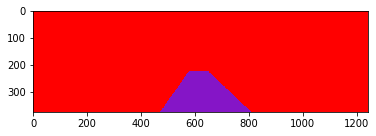

In [531]:
cv2.fillPoly( im, lane, (199,21,133) )
plt.imshow(im[:,:,::-1])


True

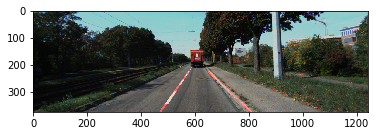

In [494]:
initial_image = image.astype('uint8')
alpha=0.8
beta=1
gamma=0
annotated_image = cv2.addWeighted(initial_image, alpha, mask_line_image, beta, gamma)
plt.imshow(annotated_image[:,:,::-1])
cv2.imwrite('1.png',annotated_image)

In [513]:
cv2.fillPoly??

In [490]:
cv2.addWeighted??

In [464]:
test_path = 'test_data'
save_path = 'draw_image'
for file in os.listdir(test_path):
    file_path = test_path+'/'+file
    image = cv2.imread(file_path)
    height,width,__ = image.shape
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    thres_light = 200
    t = gray_image
    im_thres = t.copy()
    for x,y in zip(*np.where(t<thres_light)):
        im_thres[x,y] = 0


    kernel_size = 9
    gray_blur = cv2.GaussianBlur(im_thres, (kernel_size, kernel_size), 0)


    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(gray_blur, low_threshold, high_threshold)


    imshape = image.shape
    trap_bottom_width = 0.65  # width of bottom edge of trapezoid, expressed as percentage of image width
    trap_top_width = 0.07  # ditto for top edge of trapezoid
    trap_height = 0.4  
    vertices = np.array([[\
            ((imshape[1] * (1 - trap_bottom_width)) // 2, imshape[0]),\
            ((imshape[1] * (1 - trap_top_width)) // 2, imshape[0] - imshape[0] * trap_height),\
            (imshape[1] - (imshape[1] * (1 - trap_top_width)) // 2, imshape[0] - imshape[0] * trap_height),\
            (imshape[1] - (imshape[1] * (1 - trap_bottom_width)) // 2, imshape[0])]]\
            , dtype=np.int32)
    mask_color = 255
    mask = np.zeros_like(gray_blur)
    verices = []
    cv2.fillPoly(mask, vertices,mask_color)
    masked_image = cv2.bitwise_and(gray_blur, mask)

    rho = 2 
    theta = 1 * np.pi/180 
    threshold = 15     
    min_line_len =  10 
    max_line_gap = 20    
    lines = cv2.HoughLinesP(masked_image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    new_lines = remote_outliners_line(lines)

    line_img = np.zeros((*masked_image.shape, 3), dtype=np.uint8)
    right_lines,left_lines = classify_left_right_line(new_lines,line_img)
    mask_line_image = draw_lines(right_lines,left_lines,line_img)
    
    initial_image = image.astype('uint8')
    annotated_image = weighted_img(mask_line_image, initial_image)

    file_save = save_path +'/' + file
    cv2.imwrite(file_save,annotated_image)

In [41]:

x, y, z = image.shape
image_2d = image.reshape(x*y, z)
image_2d.shnew_lines = remote_outliners_line(lines)ape

(465750, 3)

In [42]:
kmeans_cluster = cluster.KMeans(n_clusters=5)
kmeans_cluster.fit(image_2d)
cluster_centers = kmeans_cluster.cluster_centers_
cluster_labels = kmeans_cluster.labels_

In [43]:
dm = cluster_centers[cluster_labels].reshape(x, y, z)

In [44]:
cv2.imwrite('test.png',dm)

True

In [21]:

plt.figure(figsize = (15,8))
plt.imshow(cluster_centers[cluster_labels].reshape(x, y, z))

TypeError: 'tuple' object cannot be interpreted as an integer

<Figure size 1080x576 with 0 Axes>